In [1]:
# Import:
import numpy as np
import matplotlib.pyplot as plt
import dill
import sys
import os

sys.path.append("/home/mattg/D_CODE") # A questo punto è necessario per non doverlo chiamare i file che usano D_CODE.

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..'))) # include parent directory in the path
from toolbox.experiment import Experiment
from toolbox.SINDy import SINDy
from toolbox.symbolic_SINDy import symbolic_SINDy
from toolbox.cusum import CUSUM
from toolbox.auxiliary_functions import set_param_freq
from data import SINDy_data, equations

# Seed:
np.random.seed(999)

/home/mattg/miniforge3/envs/SimbSINDy_env/lib/python3.11/site-packages/pysindy/__init__.py:1: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound


In [2]:
# Select ODE:
ode_name = 'OscillatingSelkovODE_d'
ode_param = '0.8,0.1'
freq = 10
ode_param, freq = set_param_freq(ode_param, freq)
ode = equations.get_ode(ode_name, ode_param)

# Parameters:

freq_SR = 20
n_sample = 50 
noise_ratio = 0.01
seed = 100 
n_seed = 1 
dt = 1 / freq
dim_x = 3
dim_k = 0
SW_length = 15 # SINDy sliding window length
SW_length_SR = 10 # SR sliding window length
H = 70 # length of the experiment
lazy = False # if True, we do not recompute the building blocks with SR
symbolic = True # if True, SR call is allowed, otw. simple SINDy is used throughout the whole experiment

# CUSUM parameters:
N = 10 # 10
eps = 0.01 
threshold = 0.3 

In [ ]:
# Generate data: (4min 14.1sec)
X_list, dX_list, param_list, feature_names = SINDy_data.SINDy_data(ode_name, ode_param, freq, n_sample, noise_ratio, dim_x, dim_k, 0, H)
print(np.shape(X_list), np.shape(dX_list), np.shape(param_list))
print(feature_names)

# Save data:
file_path = 'saved/data/oscillating_selkov_data.pkl'
os.makedirs(os.path.dirname(file_path), exist_ok=True)
with open(file_path, 'wb') as f:
    dill.dump((X_list, dX_list, param_list, feature_names), f)

In [3]:
# Load data:
file_path = 'saved/data/oscillating_selkov_data.pkl'
with open(file_path, 'rb') as f:
    X_list, dX_list, param_list, feature_names = dill.load(f)

In [4]:
# Initialize experiment and model discovery methods:
exp = Experiment(ode, ode_param, freq_SR, n_sample, noise_ratio, seed, n_seed, dt, dim_x, dim_k, SW_length, SW_length_SR, H, lazy, symbolic)

cusum = CUSUM(N, eps, threshold)

SINDy_method = SINDy(degree=3, include_bias=True, threshold=0.08)

SR_method = 'SR-T' # symbolic regression method chosen 
x_id = 0  # equation to be identified by SR 
symbolic_SINDy_method = symbolic_SINDy(SR_method, x_id=0, degree=3)

In [5]:
# Run the experiment:

while exp.T <= exp.H:

    print(f't: {exp.T}')

    # update time-window:
    X_list_t = [x[(exp.T0*freq):(exp.T*freq)] for x in X_list]
    dX_list_t = [dx[(exp.T0*freq):(exp.T*freq)] for dx in dX_list]  

    exp.step_forward(SINDy_method, symbolic_SINDy_method, cusum, X_list_t, dX_list_t, param_list, feature_names)

    # building block search time: 3m 15s
    # total time: 6m 20s

t: 15
SINDy model:
(X0)' = 0.697 1 + 0.247 X1 + -0.279 X0 X1 + -0.122 X1^2 + -0.843 X0 X1^2
(X1)' = 0.100 X0 + -0.994 X1 + 0.994 X0 X1^2
(X2)' = 1.000 1
Model complexity:  9
Lasso penalty:  5.276726837375879
RMSE:  0.019258654679529034

t: 16
RMSE:  0.019098099159767536

t: 17
RMSE:  0.023194719454030052

t: 18
RMSE:  0.022521140436825904

t: 19
RMSE:  0.02198516848368918

t: 20
RMSE:  0.01962985839412783

t: 21
RMSE:  0.02491354356371651

t: 22
RMSE:  0.025506702358269497

t: 23
RMSE:  0.024275267966721813

t: 24
RMSE:  0.024038538791355916

t: 25
RMSE:  0.022410335500789646

t: 26
RMSE:  0.022781034219538754

t: 27
RMSE:  0.02089843717941

t: 28
RMSE:  0.022667926803057466

t: 29
RMSE:  0.02254447594346941

t: 30
RMSE:  0.024642007582948083

t: 31
RMSE:  0.036709664557431756

t: 32
RMSE:  0.042268276737883456

t: 33
RMSE:  0.05064950980162379

t: 34
RMSE:  0.05983509789609098

t: 35
RMSE:  0.06353962403580708

t: 36
RMSE:  0.08023501440975832

t: 37
RMSE:  0.08613686835516504

t: 38


/home/mattg/miniforge3/envs/SimbSINDy_env/lib/python3.11/site-packages/gplearn/functions.py:132: RuntimeWarning: overflow encountered in power
  return np.where(np.logical_and(np.minimum(x1, x2) >= 0, np.maximum(x1, x2) <= 10), np.power(x1, x2), 1000)


   1     4.23          211.354        7         0.231003         0.238234      1.72m
   2     3.74          1568.51        7          0.22552         0.224912      1.27m
   3     4.71          76469.3       16         0.216506         0.222766     51.76s


/home/mattg/miniforge3/envs/SimbSINDy_env/lib/python3.11/site-packages/gplearn/functions.py:132: RuntimeWarning: overflow encountered in power
  return np.where(np.logical_and(np.minimum(x1, x2) >= 0, np.maximum(x1, x2) <= 10), np.power(x1, x2), 1000)


   4     7.22          47.1136       18         0.181364         0.188522     29.10s
   5     7.35          54.7141       18         0.181608         0.183287      0.00s

SR-T model:  sin(-C*X2 + C + 2*X2**C)

building blocks:
-sin(3.2410061383494995*X2 - 0.17461618862005224)
sin(3.139468980910864*X2)
-sin(3.2410061383494995*X2 - 0.20225388594721674)
-sin(3.2410061383494995*X2 - 0.2648142106347563)
-sin(3.2410061383494995*X2 - 0.16215838256749218)
-3.139468980910864*X2 + X2**1.8842541798778392 + X2**2.182075682230325 + 0.8305521946504155
 
number of building blocks:  6
 


/home/mattg/miniforge3/envs/SimbSINDy_env/lib/python3.11/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.09) and eliminated all coefficients
  warnings.warn(
/home/mattg/miniforge3/envs/SimbSINDy_env/lib/python3.11/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.09) and eliminated all coefficients
  warnings.warn(
/home/mattg/miniforge3/envs/SimbSINDy_env/lib/python3.11/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.09) and eliminated all coefficients
  warnings.warn(
/home/mattg/miniforge3/envs/SimbSINDy_env/lib/python3.11/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.09) and eliminated all coefficients
  warnings.warn(
/home/mattg/miniforge3/envs/SimbSINDy_env/lib/python3.11/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.09) and eliminated all coefficients
  

No model update, all smart-SINDy models are too complex
RMSE:  0.16381472599467475

t: 42


/home/mattg/miniforge3/envs/SimbSINDy_env/lib/python3.11/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.09) and eliminated all coefficients
  warnings.warn(
/home/mattg/miniforge3/envs/SimbSINDy_env/lib/python3.11/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.09) and eliminated all coefficients
  warnings.warn(
/home/mattg/miniforge3/envs/SimbSINDy_env/lib/python3.11/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.09) and eliminated all coefficients
  warnings.warn(
/home/mattg/miniforge3/envs/SimbSINDy_env/lib/python3.11/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.09) and eliminated all coefficients
  warnings.warn(
/home/mattg/miniforge3/envs/SimbSINDy_env/lib/python3.11/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.09) and eliminated all coefficients
  

No model update, all smart-SINDy models are too complex
RMSE:  0.20784262385588637

t: 43


/home/mattg/miniforge3/envs/SimbSINDy_env/lib/python3.11/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.09) and eliminated all coefficients
  warnings.warn(
/home/mattg/miniforge3/envs/SimbSINDy_env/lib/python3.11/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.09) and eliminated all coefficients
  warnings.warn(
/home/mattg/miniforge3/envs/SimbSINDy_env/lib/python3.11/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.09) and eliminated all coefficients
  warnings.warn(
/home/mattg/miniforge3/envs/SimbSINDy_env/lib/python3.11/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.09) and eliminated all coefficients
  warnings.warn(
/home/mattg/miniforge3/envs/SimbSINDy_env/lib/python3.11/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.09) and eliminated all coefficients
  

No model update, all smart-SINDy models are too complex
RMSE:  0.17063124356375095

t: 44


/home/mattg/miniforge3/envs/SimbSINDy_env/lib/python3.11/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.09) and eliminated all coefficients
  warnings.warn(


No model update, all smart-SINDy models are too complex
RMSE:  0.19569066289684983

t: 45


/home/mattg/miniforge3/envs/SimbSINDy_env/lib/python3.11/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.09) and eliminated all coefficients
  warnings.warn(
/home/mattg/miniforge3/envs/SimbSINDy_env/lib/python3.11/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.09) and eliminated all coefficients
  warnings.warn(
/home/mattg/miniforge3/envs/SimbSINDy_env/lib/python3.11/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.09) and eliminated all coefficients
  warnings.warn(



Best building block:
['sin(3.139468980910864*X2)']

smart-SINDy model:
(X0)' = 0.545 1 + 0.703 X0 + 0.473 X1 + -0.452 X0^2 + -1.113 X0 X1 + 0.602 X0^2 X1 + -1.102 X0 X1^2 + 0.948 sin(3.139468980910864*X2)
(X1)' = -0.995 X1 + 0.250 X0 X1 + 0.844 X0 X1^2
(X2)' = 1.000 1
Model complexity:  12
Lasso penalty:  9.026821427799366
RMSE:  0.025334732664266807

t: 46
RMSE:  0.02529767420186251

t: 47
RMSE:  0.02778672277874855

t: 48
RMSE:  0.018560758187309716

t: 49
RMSE:  0.02977300299361061

t: 50
RMSE:  0.027761012232402495

t: 51
RMSE:  0.026815153355793302

t: 52
RMSE:  0.03264533551504933

t: 53
RMSE:  0.021133237060869076

t: 54
RMSE:  0.022311810038965735

t: 55
RMSE:  0.027993797009556648

t: 56
RMSE:  0.017110070835692305

t: 57
RMSE:  0.029161133230754643

t: 58
RMSE:  0.02867441556644828

t: 59
RMSE:  0.02419441983194299

t: 60
RMSE:  0.028358688461443328

t: 61
RMSE:  0.02164501888115144

t: 62
RMSE:  0.019585579073111297

t: 63
RMSE:  0.02849615823325573

t: 64
RMSE:  0.01896912

plotting
(450,)
(450,)
(600,)
(600,)
plotting
(450,)
(450,)
(600,)
(600,)


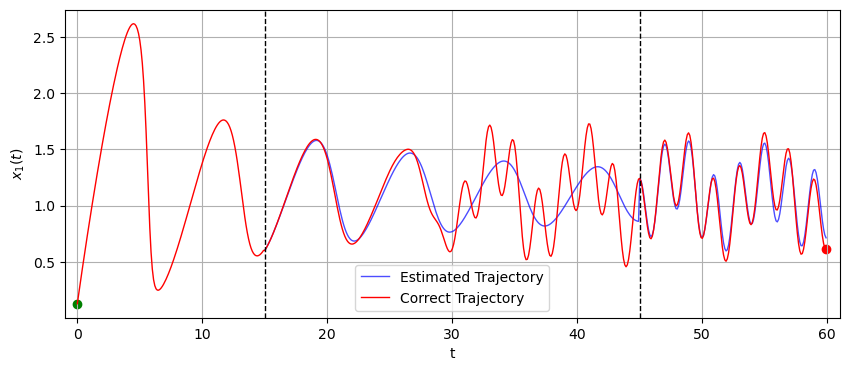

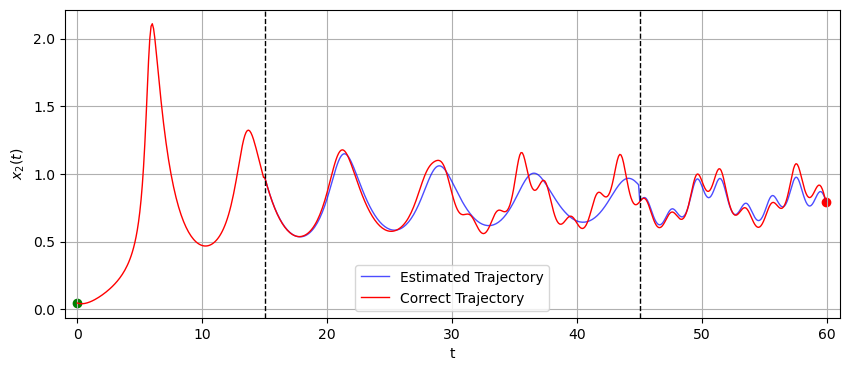

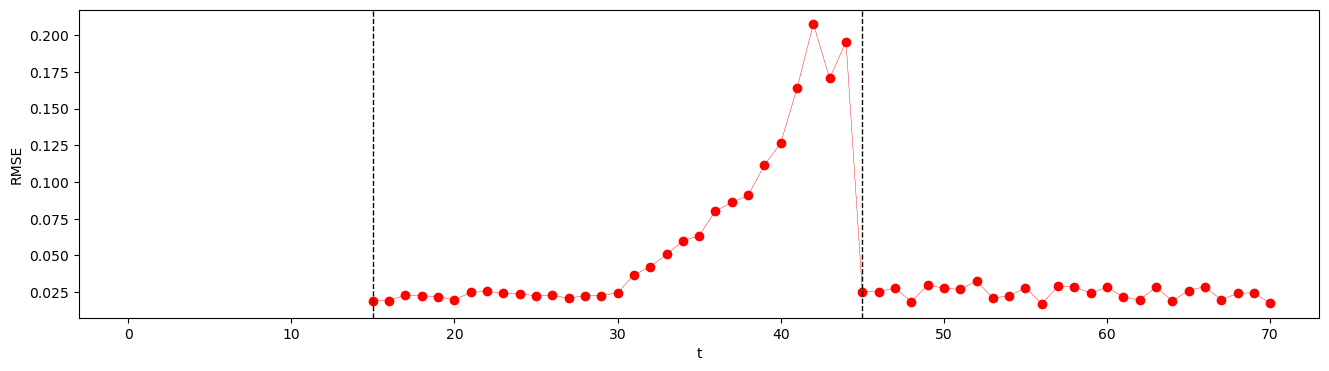

In [6]:
exp.plot()
exp.plot(x_id=1)
exp.plot_RMSE()